# Neural Networks and Deep Learning - Homework 1: Supervised Deep Learning
## Rosset Lorenzo, mat. 2021859

In [1]:
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 1

Cloning into 'NNDL'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 6), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
/content/NNDL/Homework 1


In [2]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

# Regression Task

The goal of this section is to train a neural network to approximate an unknown function

$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$

Training points are noisy measures from the target distribution
$$
\hat{y} = f(x) + noise
$$

## Dataset and Dataloader

In [3]:
train_data = pd.read_csv('regression_dataset/train_data.csv')
test_data = pd.read_csv('regression_dataset/test_data.csv')

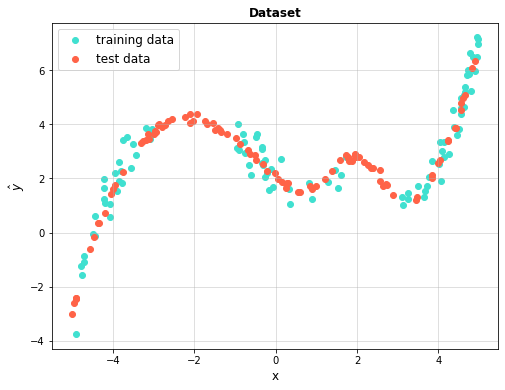

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(train_data.input, train_data.label, color='turquoise', label='training data')
plt.scatter(test_data.input, test_data.label, color='tomato', label='test data')
plt.xlabel('x', size=12)
plt.ylabel(r'$\hat{y}$', size=12)
plt.title('Dataset', size=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.5);

In [4]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [24]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

print('Number of items in the training set:', train_dataset.__len__())
print('Number of items in the test set:', test_dataset.__len__())

Number of items in the training set: 100
Number of items in the test set: 100


In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

Since the number of samples in the training set is quite small, a good idea is to evaluate the model's performaces using the cross-validation strategy

## Basic Regression Task

### Network definition

In [95]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [96]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [97]:
# Initialize the network
torch.manual_seed(1)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
torch.save(net.state_dict(), 'reg_base_model.pt')
net.to(device)

Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): ReLU()
)

In [98]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

### Training Loop

In [99]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss = []
    model.train()
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = model(x_batch)
        loss = loss_fn(out, label_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch(model, device, dataloader, loss_fn):
    val_loss = []
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)

In [100]:
### TRAINING LOOP
num_epochs = 1500
train_loss_log = []
test_loss_log = []
for epoch_num in range(num_epochs):
    ### TRAIN
    train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    ### TEST
    test_loss= val_epoch(net, device, test_dataloader, loss_fn)
    test_loss_log.append(test_loss)

    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}'.format(epoch_num + 1, num_epochs, train_loss, test_loss))

Epoch 1/1500, avg train loss: 7.534, avg test loss: 3.844
Epoch 2/1500, avg train loss: 3.131, avg test loss: 3.939
Epoch 3/1500, avg train loss: 2.679, avg test loss: 3.201
Epoch 4/1500, avg train loss: 2.452, avg test loss: 2.867
Epoch 5/1500, avg train loss: 2.263, avg test loss: 2.726
Epoch 6/1500, avg train loss: 2.064, avg test loss: 2.441
Epoch 7/1500, avg train loss: 1.985, avg test loss: 2.228
Epoch 8/1500, avg train loss: 1.876, avg test loss: 2.094
Epoch 9/1500, avg train loss: 1.934, avg test loss: 1.984
Epoch 10/1500, avg train loss: 2.014, avg test loss: 1.945
Epoch 11/1500, avg train loss: 2.063, avg test loss: 1.840
Epoch 12/1500, avg train loss: 1.848, avg test loss: 1.901
Epoch 13/1500, avg train loss: 1.762, avg test loss: 1.661
Epoch 14/1500, avg train loss: 1.677, avg test loss: 1.601
Epoch 15/1500, avg train loss: 1.539, avg test loss: 1.508
Epoch 16/1500, avg train loss: 1.522, avg test loss: 1.447
Epoch 17/1500, avg train loss: 1.488, avg test loss: 1.380
Epoch 

### Plot Losses

Final test loss (avg): 0.096362606


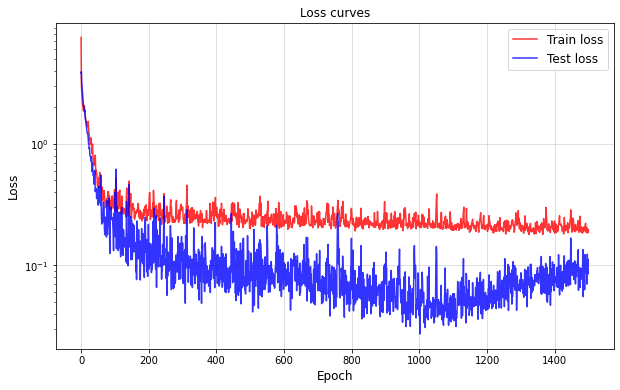

In [101]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(test_loss_log, c='blue', label='Test loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

print('Final test loss (avg):', np.mean(test_loss_log[-20:]))

The fact that the test loss is smaller than the train loss can be explained by noting that training data are more spread around than test data, while the average is the same

### Results

In [102]:
x_vec = torch.linspace(-5, 5, 200).to(device).unsqueeze(-1)
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)
    
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

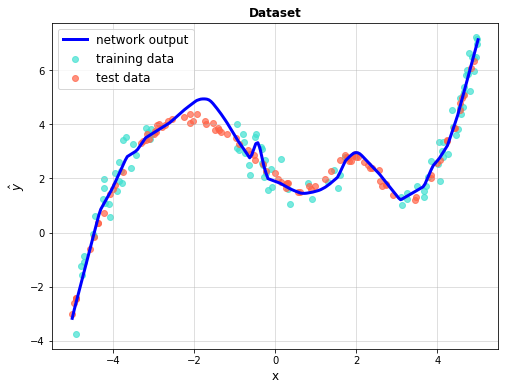

In [103]:
plt.figure(figsize=(8,6))
plt.scatter(train_data.input, train_data.label, color='turquoise', label='training data', alpha=0.7)
plt.scatter(test_data.input, test_data.label, color='tomato', label='test data', alpha=0.7)
plt.plot(x_vec, y_vec, c='blue', label='network output', lw=3)
plt.xlabel('x', size=12)
plt.ylabel(r'$\hat{y}$', size=12)
plt.title('Dataset', size=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.5);

## Advanced Optimizers and Regularization Methods

In this section we are going to use the test set in order to evaluate the generaization capabilities of models with different architectures or being trained with different optimizers. Since we lack a validation set, we can use the cross-validation strategy on the training set in order to select the best model/optimizer and, eventually, evaluate the performances of each model on the test set.

### Different optimizers

We can test the performances of some of the most common optimizars: Adam, Adadelta, Adagrad, RMSprop

In [15]:
def reset_weights(net):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

def train_model(model, num_folds, num_epochs, batch_size, device, train_dataset, test_dataset, loss_fn, optimizer, seed, verbose=True):
    test_dataloader = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)
    train_loss_log = []
    val_loss_log = []
    test_loss_log = []
    splits = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(splits.split(train_dataset)):
        if verbose:
            print(f'\nFold {fold+1}\n')
        model.apply(reset_weights) # Reset the network
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
        history = {'train_loss' : [], 'val_loss' : []}

        for epoch in range(num_epochs):
            train_loss = train_epoch(model, device, train_loader, loss_fn, optimizer)
            val_loss = val_epoch(model, device, val_loader, loss_fn)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            if verbose:
                print("Epoch:{}/{}, AVG Training Loss:{:.3f}, AVG Val Loss:{:.3f}".format(epoch + 1, num_epochs, train_loss, val_loss))
        train_loss_log.append(history['train_loss'])
        val_loss_log.append(history['val_loss'])

        # Evaluate the trained model on the test set
        test_loss = val_epoch(model, device, test_dataloader, loss_fn)
        test_loss_log.append(test_loss)

    avg_train_loss = np.mean(train_loss_log, axis=0)
    avg_val_loss = np.mean(val_loss_log, axis=0)
    avg_test_loss = np.mean(test_loss_log)
    return avg_train_loss, avg_val_loss, avg_test_loss

In [ ]:
optimizer_names = ['Adam', 'Adagrad', 'Adadelta', 'RMSprop']

train_curves = []
val_curves = []
test_losses = []
for optimizer_name in optimizer_names:
    print('\n---------------------------')
    print('Optimizer:', optimizer_name)
    print('---------------------------\n')
    model = Net(Ni, Nh1, Nh2, No)
    model.to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=1e-3)
    avg_train_loss, avg_val_loss, avg_test_loss = train_model(model, 5, 500, 10, device, train_dataset, test_dataset, loss_fn, optimizer, 2022)
    train_curves.append(avg_train_loss)
    val_curves.append(avg_val_loss)
    test_losses.append(avg_test_loss)

Streaming output truncated to the last 5000 lines.
Epoch:34/500, AVG Training Loss:11.385, AVG Val Loss:7.878
Epoch:35/500, AVG Training Loss:11.336, AVG Val Loss:7.835
Epoch:36/500, AVG Training Loss:11.286, AVG Val Loss:7.793
Epoch:37/500, AVG Training Loss:11.237, AVG Val Loss:7.751
Epoch:38/500, AVG Training Loss:11.188, AVG Val Loss:7.708
Epoch:39/500, AVG Training Loss:11.139, AVG Val Loss:7.667
Epoch:40/500, AVG Training Loss:11.091, AVG Val Loss:7.625
Epoch:41/500, AVG Training Loss:11.042, AVG Val Loss:7.583
Epoch:42/500, AVG Training Loss:10.993, AVG Val Loss:7.541
Epoch:43/500, AVG Training Loss:10.945, AVG Val Loss:7.500
Epoch:44/500, AVG Training Loss:10.896, AVG Val Loss:7.458
Epoch:45/500, AVG Training Loss:10.848, AVG Val Loss:7.417
Epoch:46/500, AVG Training Loss:10.800, AVG Val Loss:7.375
Epoch:47/500, AVG Training Loss:10.752, AVG Val Loss:7.334
Epoch:48/500, AVG Training Loss:10.704, AVG Val Loss:7.293
Epoch:49/500, AVG Training Loss:10.655, AVG Val Loss:7.252
Epoch

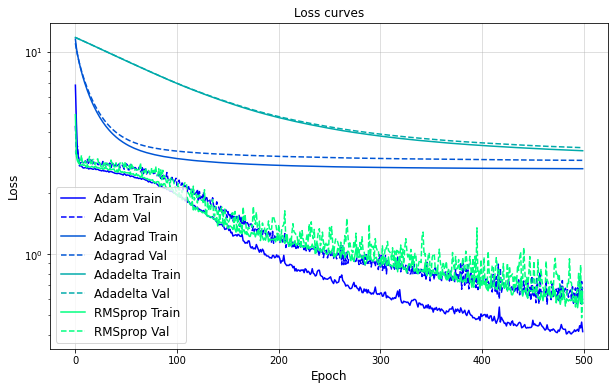

In [ ]:
# Visualization of training curves
colors = cm.get_cmap('winter', len(optimizer_names))
plt.figure(figsize=(10,6))
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

for i, (train_curve, val_curve, label) in enumerate(zip(train_curves, val_curves, optimizer_names)):
    plt.plot(train_curve, c=colors(i), label=label + ' Train')
    plt.plot(val_curve, c=colors(i), ls='--', label=label + ' Val')

plt.legend(fontsize='12');

This time, having used the training set also for the validation, we see that the validation loss is, ax expected, below the training loss

Adam test loss: 0.6360674


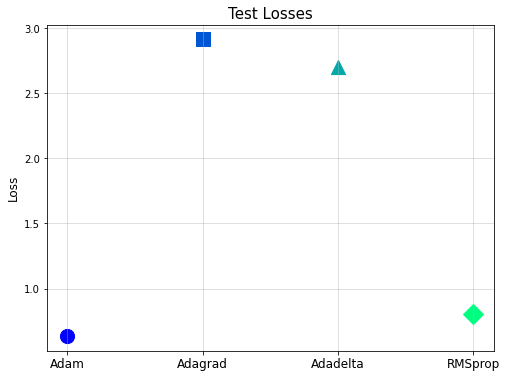

In [ ]:
# Visualization of performaces on the test set
plt.figure(figsize=(8,6))
plt.ylabel('Loss', size=12)
plt.title('Test Losses', size=15)
plt.grid(axis='both', alpha=0.5)
markers = ['o', 's', '^', 'D']

for i in range(len(optimizer_names)):
    plt.scatter([i], [test_losses[i]], s=200, color=colors(i), marker=markers[i])

plt.xticks(ticks=[0,1,2,3], labels=optimizer_names, rotation=0, size=12);
print('Adam test loss:', test_losses[0])

A more advanced way is to use Optuna

In [ ]:
!pip install optuna
import optuna
from optuna.trial import TrialState

In [77]:
optimizer_names = ['Adam', 'Adagrad', 'Adadelta', 'RMSprop']

def objective(trial):

    # Generate the model
    model = Net(Ni, Nh1, Nh2, No).to(device)

    # Generate optimizer
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model with cross-validation
    avg_train_loss, avg_val_loss, avg_test_loss = train_model(model, 5, 20, 10, device, train_dataset, test_dataset, loss_fn, optimizer, 2022, False)
    return np.mean(avg_val_loss[-10:])

In [78]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-03-18 09:11:11,269] A new study created in memory with name: no-name-3d362a31-eaf9-410d-800a-334850eb6a8c


Network initialized


[I 2022-03-18 09:11:13,469] Trial 0 finished with value: 2.031886577606201 and parameters: {'optimizer': 'Adam', 'lr': 0.014743586117093572}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:15,498] Trial 1 finished with value: 2.88435435295105 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00039767331902758134}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:17,703] Trial 2 finished with value: 2.93084454536438 and parameters: {'optimizer': 'Adam', 'lr': 0.05896904002014096}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:19,724] Trial 3 finished with value: 3.2839980125427246 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00011846388587551285}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:21,946] Trial 4 finished with value: 3.382549285888672 and parameters: {'optimizer': 'Adadelta', 'lr': 0.04030050594810405}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:24,285] Trial 5 finished with value: 3.2540087699890137 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001244702633419635}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:26,537] Trial 6 finished with value: 10.485237121582031 and parameters: {'optimizer': 'Adadelta', 'lr': 0.000899721185543342}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:28,594] Trial 7 finished with value: 2.4581825733184814 and parameters: {'optimizer': 'RMSprop', 'lr': 0.007954119267213698}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:30,758] Trial 8 finished with value: 2.123128890991211 and parameters: {'optimizer': 'Adam', 'lr': 0.011033790581474443}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:32,996] Trial 9 finished with value: 7.327509880065918 and parameters: {'optimizer': 'Adadelta', 'lr': 0.007848166726146563}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:34,993] Trial 10 finished with value: 11.507928848266602 and parameters: {'optimizer': 'Adagrad', 'lr': 2.5205618536165527e-05}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:37,183] Trial 11 finished with value: 2.2664105892181396 and parameters: {'optimizer': 'Adam', 'lr': 0.008537333269304427}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:39,391] Trial 12 finished with value: 2.740401268005371 and parameters: {'optimizer': 'Adam', 'lr': 0.003694702607170519}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:41,556] Trial 13 finished with value: 2.489490032196045 and parameters: {'optimizer': 'Adam', 'lr': 0.03898961412059121}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:43,771] Trial 14 finished with value: 2.8394527435302734 and parameters: {'optimizer': 'Adam', 'lr': 0.0022902100572547075}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:45,796] Trial 15 finished with value: 2.8089654445648193 and parameters: {'optimizer': 'Adagrad', 'lr': 0.016881155134884796}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:48,938] Trial 16 finished with value: 2.8634047508239746 and parameters: {'optimizer': 'Adam', 'lr': 0.0016606665560199778}. Best is trial 0 with value: 2.031886577606201.


Network initialized


[I 2022-03-18 09:11:52,390] Trial 17 finished with value: 1.961896300315857 and parameters: {'optimizer': 'Adam', 'lr': 0.01801178192661441}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:11:54,588] Trial 18 finished with value: 4.255297660827637 and parameters: {'optimizer': 'Adam', 'lr': 0.09810096077095146}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:11:56,570] Trial 19 finished with value: 2.8446450233459473 and parameters: {'optimizer': 'Adagrad', 'lr': 0.019397129316952026}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:11:58,775] Trial 20 finished with value: 2.860426664352417 and parameters: {'optimizer': 'Adam', 'lr': 0.0005974212862812534}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:00,950] Trial 21 finished with value: 2.0358049869537354 and parameters: {'optimizer': 'Adam', 'lr': 0.01565476219672289}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:03,137] Trial 22 finished with value: 2.7150981426239014 and parameters: {'optimizer': 'Adam', 'lr': 0.004163534805631475}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:05,296] Trial 23 finished with value: 2.221666097640991 and parameters: {'optimizer': 'Adam', 'lr': 0.02301473811911148}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:07,466] Trial 24 finished with value: 2.674959421157837 and parameters: {'optimizer': 'Adam', 'lr': 0.004457721335259201}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:09,638] Trial 25 finished with value: 3.6787867546081543 and parameters: {'optimizer': 'Adam', 'lr': 0.09966292279703426}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:11,798] Trial 26 finished with value: 2.143113136291504 and parameters: {'optimizer': 'Adam', 'lr': 0.028511814176901438}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:13,789] Trial 27 finished with value: 3.3631603717803955 and parameters: {'optimizer': 'Adagrad', 'lr': 0.0016164930517771766}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:16,018] Trial 28 finished with value: 13.005081176757812 and parameters: {'optimizer': 'Adadelta', 'lr': 1.1991588719890194e-05}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:18,037] Trial 29 finished with value: 2.9615437984466553 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00022299395441358104}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:20,268] Trial 30 finished with value: 2.029510021209717 and parameters: {'optimizer': 'Adam', 'lr': 0.01461260751106019}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:22,432] Trial 31 finished with value: 2.164641857147217 and parameters: {'optimizer': 'Adam', 'lr': 0.011788058165603015}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:24,591] Trial 32 finished with value: 3.266667127609253 and parameters: {'optimizer': 'Adam', 'lr': 0.05835265421773608}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:26,760] Trial 33 finished with value: 2.531534194946289 and parameters: {'optimizer': 'Adam', 'lr': 0.005845279948008202}. Best is trial 17 with value: 1.961896300315857.


Network initialized


[I 2022-03-18 09:12:28,915] Trial 34 finished with value: 1.884060263633728 and parameters: {'optimizer': 'Adam', 'lr': 0.015185218829038312}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:31,155] Trial 35 finished with value: 2.8012428283691406 and parameters: {'optimizer': 'Adam', 'lr': 0.0027628611517079827}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:33,203] Trial 36 finished with value: 6.200698375701904 and parameters: {'optimizer': 'RMSprop', 'lr': 0.035346613169343136}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:35,427] Trial 37 finished with value: 3.0532455444335938 and parameters: {'optimizer': 'Adadelta', 'lr': 0.0546033375081293}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:37,617] Trial 38 finished with value: 2.079110622406006 and parameters: {'optimizer': 'Adam', 'lr': 0.02471709310560936}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:39,690] Trial 39 finished with value: 2.636293888092041 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0125462114965329}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:41,939] Trial 40 finished with value: 7.463720798492432 and parameters: {'optimizer': 'Adadelta', 'lr': 0.0066486610801062785}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:44,094] Trial 41 finished with value: 2.082318067550659 and parameters: {'optimizer': 'Adam', 'lr': 0.01449266979460795}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:46,240] Trial 42 finished with value: 2.1879749298095703 and parameters: {'optimizer': 'Adam', 'lr': 0.010198197408356317}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:48,410] Trial 43 finished with value: 2.644909381866455 and parameters: {'optimizer': 'Adam', 'lr': 0.04563291920729114}. Best is trial 34 with value: 1.884060263633728.


Network initialized


[I 2022-03-18 09:12:50,641] Trial 44 finished with value: 1.8633995056152344 and parameters: {'optimizer': 'Adam', 'lr': 0.018370765020086853}. Best is trial 44 with value: 1.8633995056152344.


Network initialized


[I 2022-03-18 09:12:52,818] Trial 45 finished with value: 2.0748085975646973 and parameters: {'optimizer': 'Adam', 'lr': 0.03142187651738819}. Best is trial 44 with value: 1.8633995056152344.


Network initialized


[I 2022-03-18 09:12:54,984] Trial 46 finished with value: 4.53776741027832 and parameters: {'optimizer': 'Adam', 'lr': 6.750291621345908e-05}. Best is trial 44 with value: 1.8633995056152344.


Network initialized


[I 2022-03-18 09:12:56,979] Trial 47 finished with value: 2.9461398124694824 and parameters: {'optimizer': 'Adagrad', 'lr': 0.005542910945980627}. Best is trial 44 with value: 1.8633995056152344.


Network initialized


[I 2022-03-18 09:12:59,151] Trial 48 finished with value: 2.21954345703125 and parameters: {'optimizer': 'Adam', 'lr': 0.008335044386172765}. Best is trial 44 with value: 1.8633995056152344.


Network initialized


[I 2022-03-18 09:13:01,335] Trial 49 finished with value: 3.5829901695251465 and parameters: {'optimizer': 'Adam', 'lr': 0.06983397053375709}. Best is trial 44 with value: 1.8633995056152344.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  1.8633995056152344
  Params: 
    optimizer: Adam
    lr: 0.018370765020086853


### Regularization methods

Some regularization methods include weight decay (L2) and Dropout. We can compare the performances on the test set without any regularization, with only weight regularization, with only dropout and with both regularization and dropout

In [ ]:
class Net_reg(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.dropout = nn.Dropout(p=0.2)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
# Initialize the network
torch.manual_seed(1)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1

# Define the loss function
loss_fn = nn.MSELoss()

In [ ]:
net1 = Net(Ni, Nh1, Nh2, No)
net1.to(device)

# Define the optimizer
optimizer = optim.Adam(net1.parameters(), lr=1e-3)

### Training loop
num_epochs = 1000
train_loss_log1 = []
test_loss_log1 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net1, device, train_dataloader, loss_fn, optimizer)
    train_loss_log1.append(train_loss)

    test_loss = val_epoch(net1, device, test_dataloader, loss_fn)
    test_loss_log1.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 6.340, test loss: 3.326
Epoch 1, train loss: 3.438, test loss: 2.685
Epoch 2, train loss: 2.835, test loss: 2.814
Epoch 3, train loss: 2.705, test loss: 2.904
Epoch 4, train loss: 2.684, test loss: 2.945
Epoch 5, train loss: 2.667, test loss: 2.949
Epoch 6, train loss: 2.691, test loss: 2.930
Epoch 7, train loss: 2.679, test loss: 2.885
Epoch 8, train loss: 2.702, test loss: 2.862
Epoch 9, train loss: 2.698, test loss: 2.917
Epoch 10, train loss: 2.689, test loss: 2.787
Epoch 11, train loss: 2.789, test loss: 2.831
Epoch 12, train loss: 2.637, test loss: 2.865
Epoch 13, train loss: 2.632, test loss: 2.847
Epoch 14, train loss: 2.603, test loss: 2.814
Epoch 15, train loss: 2.581, test loss: 2.822
Epoch 16, train loss: 2.617, test loss: 2.821
Epoch 17, train loss: 2.592, test loss: 2.797
Epoch 18, train loss: 2.676, test loss: 2.824
Epoch 19, train loss: 2.627, test loss: 2.797
Epoch 20, train loss: 2.620, test loss: 2.770
Epoch 21, train loss: 2.

In [ ]:
net2 = Net(Ni, Nh1, Nh2, No)
net2.to(device)

# Define the optimizer
optimizer = optim.Adam(net2.parameters(), lr=1e-3, weight_decay=0.002)

### Training loop
num_epochs = 1000
train_loss_log2 = []
test_loss_log2 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net2, device, train_dataloader, loss_fn, optimizer)
    train_loss_log2.append(train_loss)

    test_loss = val_epoch(net2, device, test_dataloader, loss_fn)
    test_loss_log2.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 5.900, test loss: 3.047
Epoch 1, train loss: 3.341, test loss: 2.745
Epoch 2, train loss: 2.802, test loss: 2.881
Epoch 3, train loss: 2.763, test loss: 2.853
Epoch 4, train loss: 2.687, test loss: 2.919
Epoch 5, train loss: 2.672, test loss: 2.905
Epoch 6, train loss: 2.657, test loss: 2.882
Epoch 7, train loss: 2.700, test loss: 2.918
Epoch 8, train loss: 2.660, test loss: 2.765
Epoch 9, train loss: 2.842, test loss: 2.919
Epoch 10, train loss: 2.614, test loss: 2.857
Epoch 11, train loss: 2.620, test loss: 2.836
Epoch 12, train loss: 2.625, test loss: 2.776
Epoch 13, train loss: 2.674, test loss: 2.820
Epoch 14, train loss: 2.619, test loss: 2.796
Epoch 15, train loss: 2.631, test loss: 2.816
Epoch 16, train loss: 2.618, test loss: 2.783
Epoch 17, train loss: 2.590, test loss: 2.778
Epoch 18, train loss: 2.595, test loss: 2.787
Epoch 19, train loss: 2.635, test loss: 2.758
Epoch 20, train loss: 2.596, test loss: 2.776
Epoch 21, train loss: 2.

In [ ]:
net3 = Net_reg(Ni, Nh1, Nh2, No)
net3.to(device)

# Define the optimizer
optimizer = optim.Adam(net3.parameters(), lr=1e-3)

### Training loop
num_epochs = 1000
train_loss_log3 = []
test_loss_log3 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net3, device, train_dataloader, loss_fn, optimizer)
    train_loss_log3.append(train_loss)

    test_loss = val_epoch(net3, device, test_dataloader, loss_fn)
    test_loss_log3.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 3.772, test loss: 3.364
Epoch 1, train loss: 3.041, test loss: 2.788
Epoch 2, train loss: 2.842, test loss: 3.007
Epoch 3, train loss: 2.780, test loss: 3.021
Epoch 4, train loss: 2.851, test loss: 2.983
Epoch 5, train loss: 2.937, test loss: 2.845
Epoch 6, train loss: 2.906, test loss: 2.871
Epoch 7, train loss: 2.666, test loss: 2.858
Epoch 8, train loss: 2.728, test loss: 2.836
Epoch 9, train loss: 2.730, test loss: 2.875
Epoch 10, train loss: 2.706, test loss: 2.845
Epoch 11, train loss: 2.666, test loss: 2.837
Epoch 12, train loss: 2.546, test loss: 2.869
Epoch 13, train loss: 2.666, test loss: 2.830
Epoch 14, train loss: 2.672, test loss: 2.863
Epoch 15, train loss: 2.701, test loss: 2.853
Epoch 16, train loss: 2.776, test loss: 2.779
Epoch 17, train loss: 2.720, test loss: 2.778
Epoch 18, train loss: 2.622, test loss: 2.829
Epoch 19, train loss: 2.580, test loss: 2.735
Epoch 20, train loss: 2.671, test loss: 2.787
Epoch 21, train loss: 2.

In [ ]:
net4 = Net_reg(Ni, Nh1, Nh2, No)
net4.to(device)

# Define the optimizer
optimizer = optim.Adam(net4.parameters(), lr=1e-3, weight_decay=0.002)

### Training loop
num_epochs = 1000
train_loss_log4 = []
test_loss_log4 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net4, device, train_dataloader, loss_fn, optimizer)
    train_loss_log4.append(train_loss)

    test_loss = val_epoch(net4, device, test_dataloader, loss_fn)
    test_loss_log4.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 5.052, test loss: 3.049
Epoch 1, train loss: 3.137, test loss: 2.771
Epoch 2, train loss: 2.707, test loss: 2.867
Epoch 3, train loss: 2.779, test loss: 2.888
Epoch 4, train loss: 2.702, test loss: 2.902
Epoch 5, train loss: 2.637, test loss: 2.921
Epoch 6, train loss: 2.758, test loss: 2.920
Epoch 7, train loss: 2.592, test loss: 2.914
Epoch 8, train loss: 2.607, test loss: 2.838
Epoch 9, train loss: 2.692, test loss: 2.823
Epoch 10, train loss: 2.698, test loss: 2.753
Epoch 11, train loss: 3.039, test loss: 2.911
Epoch 12, train loss: 2.652, test loss: 2.905
Epoch 13, train loss: 2.567, test loss: 2.901
Epoch 14, train loss: 2.717, test loss: 2.778
Epoch 15, train loss: 2.823, test loss: 2.750
Epoch 16, train loss: 2.676, test loss: 2.823
Epoch 17, train loss: 2.821, test loss: 2.810
Epoch 18, train loss: 2.729, test loss: 2.790
Epoch 19, train loss: 2.617, test loss: 2.767
Epoch 20, train loss: 2.545, test loss: 2.789
Epoch 21, train loss: 2.

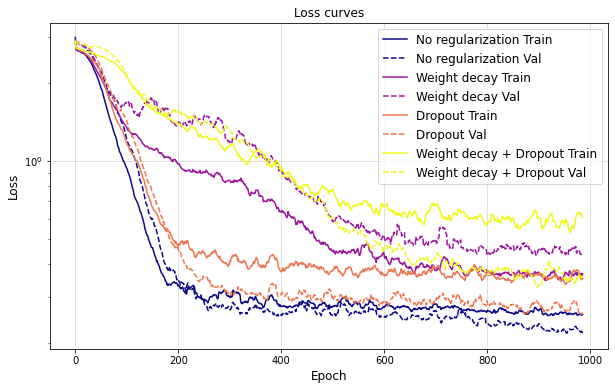

In [ ]:
def sliding_average(arr, l):
    return np.convolve(arr, np.ones(l)/l, mode='valid')

# Visualization of training curves
train_loss_logs = [sliding_average(arr, 15) for arr in [train_loss_log1, train_loss_log2, train_loss_log3, train_loss_log4]]
test_loss_logs = [sliding_average(arr, 15) for arr in [test_loss_log1, test_loss_log2, test_loss_log3, test_loss_log4]]
labels = ['No regularization', 'Weight decay', 'Dropout', 'Weight decay + Dropout']

colors = cm.get_cmap('plasma', 4)
plt.figure(figsize=(10,6))
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

for i, (train_curve, test_curve, label) in enumerate(zip(train_loss_logs, test_loss_logs, labels)):
    plt.plot(train_curve, c=colors(i), label=label + ' Train')
    plt.plot(test_curve, c=colors(i), ls='--', label=label + ' Val')

plt.legend(fontsize='12');

The data distribution is simple and thare are a lot of points along the curve, so there is "no danger of overfitting"

## Hyperparameters optimization

In [104]:
def define_model(trial):

    # optimization of number of layers, hidden units and dropout ratio
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []

    in_features = 1
    for i in range(n_layers):
        out_features = trial.suggest_int('n_units_l{}'.format(i), 20, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Sigmoid())
        p = trial.suggest_float('dropout_l{}'.format(i), 0., 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    return nn.Sequential(*layers)

def objective(trial):

    # Generate the model
    model = define_model(trial).to(device)

    # Generate optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.018)

    # Training of the model with cross-validation
    avg_train_loss, avg_val_loss, avg_test_loss = train_model(model, 5, 20, 10, device, train_dataset, test_dataset, loss_fn, optimizer, 2022, False)
    return np.mean(avg_val_loss[-2:])

In [105]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-03-18 09:31:20,702] A new study created in memory with name: no-name-15637f22-8cd9-41e5-862e-58f0ef21155f
[I 2022-03-18 09:31:22,732] Trial 0 finished with value: 2.153632879257202 and parameters: {'n_layers': 1, 'n_units_l0': 27, 'dropout_l0': 0.38072835077837064}. Best is trial 0 with value: 2.153632879257202.
[I 2022-03-18 09:31:25,021] Trial 1 finished with value: 1.9778283834457397 and parameters: {'n_layers': 2, 'n_units_l0': 226, 'dropout_l0': 0.37672526680632373, 'n_units_l1': 168, 'dropout_l1': 0.08805195213243955}. Best is trial 1 with value: 1.9778283834457397.
[I 2022-03-18 09:31:27,317] Trial 2 finished with value: 1.1333229541778564 and parameters: {'n_layers': 2, 'n_units_l0': 51, 'dropout_l0': 0.021241268736138685, 'n_units_l1': 220, 'dropout_l1': 0.004803562913354376}. Best is trial 2 with value: 1.1333229541778564.
[I 2022-03-18 09:31:29,620] Trial 3 finished with value: 1.580780029296875 and parameters: {'n_layers': 2, 'n_units_l0': 43, 'dropout_l0': 0.128115

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  1.036623477935791
  Params: 
    n_layers: 2
    n_units_l0: 216
    dropout_l0: 0.06046749833074657
    n_units_l1: 116
    dropout_l1: 0.06572693262577067


Now we can train the best model selected by optuna and see if performaces are better than those obtained with the previous model

In [106]:
class Best_model(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.layers = []
        in_features = 1
        for i in range(params['n_layers']):
            self.layers.append(nn.Linear(in_features, params[f'n_units_l{i}']))
            self.layers.append(nn.Sigmoid())
            self.layers.append(nn.Dropout(params[f'dropout_l{i}']))
            in_features = params[f'n_units_l{i}']
        self.layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

In [107]:
best_net = Best_model(study.best_params)
best_net.to(device)

optimizer = optim.Adam(best_net.parameters(), lr=0.018)
loss_fn = nn.MSELoss()

In [108]:
### TRAINING LOOP
num_epochs = 1500
train_loss_log = []
test_loss_log = []
for epoch_num in range(num_epochs):

    ### TRAIN
    train_loss = train_epoch(best_net, device, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    ### TEST
    test_loss= val_epoch(best_net, device, test_dataloader, loss_fn)
    test_loss_log.append(test_loss)
    
    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}'.format(epoch_num + 1, num_epochs, train_loss, test_loss))

Epoch 1/1500, avg train loss: 5.480, avg test loss: 3.796
Epoch 2/1500, avg train loss: 3.924, avg test loss: 3.799
Epoch 3/1500, avg train loss: 3.139, avg test loss: 3.421
Epoch 4/1500, avg train loss: 3.036, avg test loss: 3.132
Epoch 5/1500, avg train loss: 2.612, avg test loss: 2.442
Epoch 6/1500, avg train loss: 2.430, avg test loss: 2.513
Epoch 7/1500, avg train loss: 2.313, avg test loss: 2.039
Epoch 8/1500, avg train loss: 1.954, avg test loss: 1.978
Epoch 9/1500, avg train loss: 1.726, avg test loss: 1.874
Epoch 10/1500, avg train loss: 1.848, avg test loss: 2.089
Epoch 11/1500, avg train loss: 1.979, avg test loss: 1.692
Epoch 12/1500, avg train loss: 1.593, avg test loss: 2.081
Epoch 13/1500, avg train loss: 1.703, avg test loss: 1.845
Epoch 14/1500, avg train loss: 1.433, avg test loss: 1.583
Epoch 15/1500, avg train loss: 1.519, avg test loss: 2.121
Epoch 16/1500, avg train loss: 1.762, avg test loss: 1.649
Epoch 17/1500, avg train loss: 1.232, avg test loss: 1.472
Epoch 

Final test loss (avg): 0.43079782


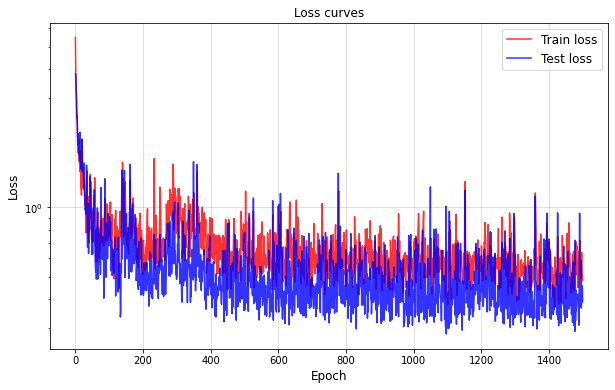

In [109]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(test_loss_log, c='blue', label='Test loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

print('Final test loss (avg):', np.mean(test_loss_log[-20:]))

In [110]:
x_vec = torch.linspace(-5, 5, 200).to(device).unsqueeze(-1)
net.eval()
with torch.no_grad():
    y_vec = best_net(x_vec)
    
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

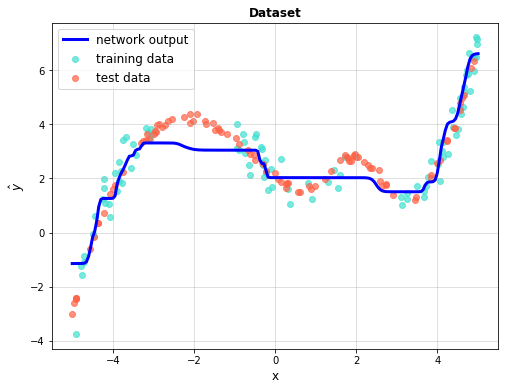

In [111]:
plt.figure(figsize=(8,6))
plt.scatter(train_data.input, train_data.label, color='turquoise', label='training data', alpha=0.7)
plt.scatter(test_data.input, test_data.label, color='tomato', label='test data', alpha=0.7)
plt.plot(x_vec, y_vec, c='blue', label='network output', lw=3)
plt.xlabel('x', size=12)
plt.ylabel(r'$\hat{y}$', size=12)
plt.title('Dataset', size=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.5);

## Access network parameters

In [112]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

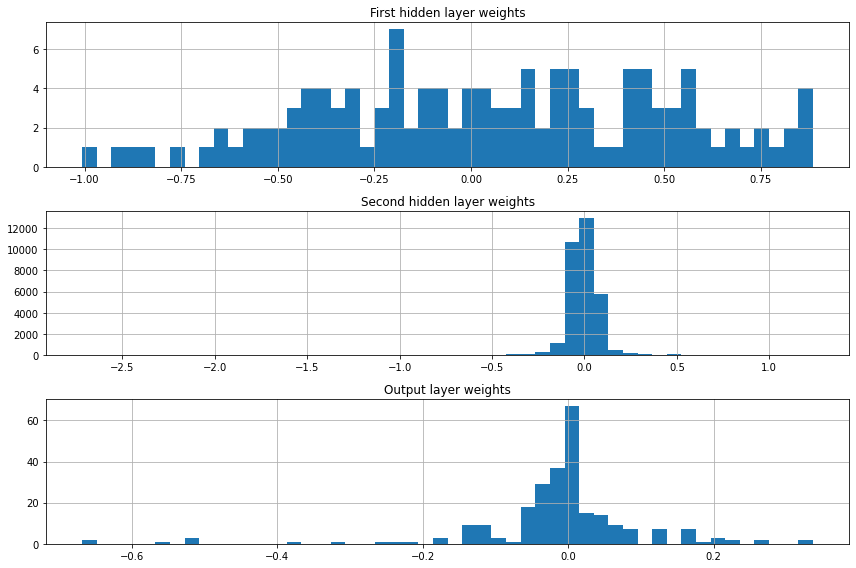

In [113]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

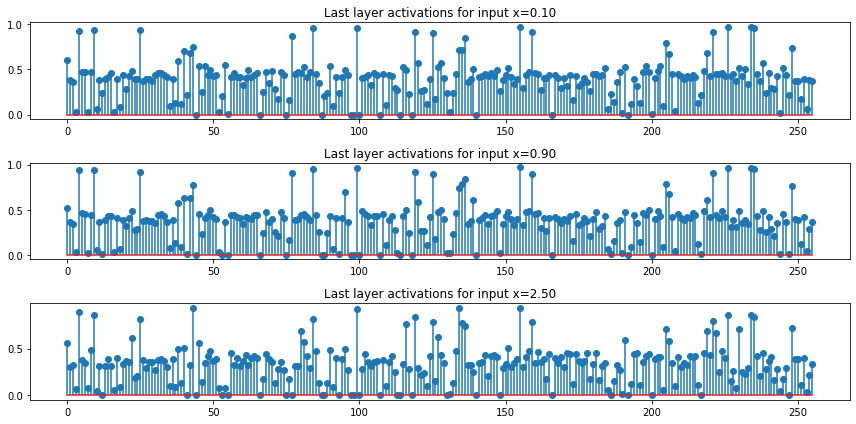

In [114]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()